Name: Amruta Rajopadhye <br />
Kaggle Username: wingjammer1993

### Problem 1

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import nltk
%matplotlib inline

In [102]:
from nltk.stem.porter import *
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# This function gives the lemmatized and stemmed sentences and the parts-of-speech tags of the sentences.
# WordNetLemmatizer and PorterStemmer is used to lemmatize and stem respectively.
# The sentence is first tokenized using nltk, the pos tags are retrieved, the words are lemmatized, stemmed,
# and rejoined to form the sentence string.
def stem_pos_sentences(examples):
    new_examples = []
    new_pos = []
    stemmer = PorterStemmer()
    lemmer = WordNetLemmatizer()
    for ex in examples:
        gen_list = word_tokenize(ex)
        pos = nltk.pos_tag(gen_list)
        pos = [p[-1] for p in pos if p[-1]]
        lemms = [lemmer.lemmatize(ex) for ex in gen_list]
        singles = [stemmer.stem(ex) for ex in lemms]
        new_examples.append(' '.join(singles))
        new_pos.append(' '.join(pos))
    return new_examples, new_pos

# This function gives the tokenized,lemmatized and stemmed tropes.
# The tropes are seperated into words using capital letters as a marker, tokenized, lemmatized and then stemmed.
def stem_pos_tropes(examples):
    new_examples = []
    stemmer = PorterStemmer()
    lemmer = WordNetLemmatizer()
    for ex in examples:
        ex = re.sub(r"\B([A-Z])", r" \1", ex)
        gen_list = word_tokenize(ex)
        lemms = [lemmer.lemmatize(ex) for ex in gen_list]
        singles = [stemmer.stem(ex) for ex in lemms]
        new_examples.append(' '.join(singles))
    return new_examples

In [100]:
class FeatEngr:
    def __init__(self):
        
        from sklearn.feature_extraction.text import TfidfVectorizer
        from sklearn.feature_extraction.text import CountVectorizer
        

        self.vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words= {'English'})
        self.tag_vectorizer = CountVectorizer()
        self.page_vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words={'English'})


    def build_train_features(self, examples):
        """
        Method to take in training text features and do further feature engineering 
        Most of the work in this homework will go here, or in similar functions  
        :param examples: currently just a list of forum posts  
        """

        import scipy as sp
        from scipy.sparse import csr_matrix
        
        # pre-processed sentences, tropes and parts of speech tags are passed on as inputs to vectorizers.
        # The output of the vectorizers is stacked to create a feature matrix of the training vector.
        
        stemmed_sentences, tags = stem_pos_sentences(list(examples["sentence"]))
        stemmed_pages = stem_pos_tropes(list(examples["trope"]))
        feature_1 = self.vectorizer.fit_transform(stemmed_sentences)
        feature_2 = self.tag_vectorizer.fit_transform(tags)
        feature_3 = self.page_vectorizer.fit_transform(stemmed_pages)
        training_vec = sp.sparse.hstack((feature_1, feature_2, feature_3))
        return training_vec

    def get_test_features(self, examples):
        """
        Method to take in test text features and transform the same way as train features 
        :param examples: currently just a list of forum posts  
        """
        import scipy as sp
        from scipy.sparse import csr_matrix
        
        # pre-processed sentences, tropes and parts of speech tags are passed on as inputs to vectorizers.
        # The output is then transformed and stacked to create a feature matrix of test vector.

        stemmed_sentences, tags = stem_pos_sentences(list(examples["sentence"]))
        stemmed_pages = stem_pos_tropes(list(examples["trope"]))
        feature_1 = self.vectorizer.transform(stemmed_sentences)
        feature_2 = self.tag_vectorizer.transform(tags)
        feature_3 = self.page_vectorizer.transform(stemmed_pages)
        test_vec = sp.sparse.hstack((feature_1, feature_2, feature_3))
        return test_vec


    def show_top10(self):
        """
        prints the top 10 features for the positive class and the 
        top 10 features for the negative class. 
        """
        feature_names = np.asarray(self.vectorizer.get_feature_names())
        top10 = np.argsort(self.logreg.coef_[0])[-10:]
        bottom10 = np.argsort(self.logreg.coef_[0])[:10]
        print("Pos: %s" % " ".join(feature_names[top10]))
        print("Neg: %s" % " ".join(feature_names[bottom10]))
                
    def train_model(self, random_state=1234):
        """
        Method to read in training data from file, and 
        train Logistic Regression classifier. 
        
        :param random_state: seed for random number generator 
        """
        
        from sklearn.linear_model import LogisticRegression 
        
        # load data 
        dfTrain = pd.read_csv("train.csv")
        
        # get training features and labels 
        self.X_train = self.build_train_features(dfTrain)
        self.y_train = np.array(dfTrain["spoiler"], dtype=int)
        
        # train logistic regression model.  !!You MAY NOT CHANGE THIS!! 
        self.logreg = LogisticRegression(random_state=random_state)
        self.logreg.fit(self.X_train, self.y_train)        
       
    def model_predict(self):
        """
        Method to read in test data from file, make predictions
        using trained model, and dump results to file 
        """
        
        # read in test data 
        dfTest  = pd.read_csv("test.csv")
        
        # featurize test data 
        self.X_test = self.get_test_features(dfTest)
        
        # make predictions on test data 
        pred = self.logreg.predict(self.X_test)
        
        # dump predictions to file for submission to Kaggle  
        pd.DataFrame({"spoiler": np.array(pred, dtype=bool)}).to_csv("prediction.csv", index=True, index_label="Id")

In [101]:
# Instantiate the FeatEngr clas 
feat = FeatEngr()

# Train your Logistic Regression classifier 
feat.train_model(random_state=1230)

# Make prediction on test data and produce Kaggle submission file 
feat.model_predict()

### Problem 2

I have the following three features for this task -

1. stemmed and lemmatized unigrams and bigrams from the sentences vectorized with tfidf.
2. tokenized, stemmed and lemmatized unigrams and bigrams of tropes vectorized with tfidf.
3. parts of speech tags for the sentences vectorized with count vectorizer.

Evaluation is done using 10-fold cross-validation, Data-analysis, misclassified examples, kaggle score and cross-val scores are used to inspect the errors.


#### 1 - cleaned unigrams and bigrams of sentences<br/>
The original model uses bag of words unigrams vectorized with a count vectorizer. This gives us a way to represent the data, but results in a large number of features, Moreover, these features consists of simple counts and give an inordinate amount of importance to frequent words.
Hence, Tfidf vectorizer is used, which helps weigh down the words which are very frequent or very rare and gives us more useful representation and smaller feature set.
Bigrams are used along with unigrams to capture relationships between the words.

Count vectorizer alone gives the following top predictors - <br/>
__Pos: dies elias harvey sebastian lex regina morgana olivia destiny moriarty<br/>
Neg: cory johnny tim often cody drew hilarious disney small labor__

It can be seen that these are extremely overfitted features and predictably do not perform well on the test set, even if it gives a cross val score of 67%, since the shows included in the training differ from those in the test set.

For example, the following sentence is misclassified as a spoiler, since the name harvey often appears in spoiler sentences and we have no other feature to help reclassify it.

*On that day's 9:00 PM newscast, KCAL co-anchor Pat Harvey, fighting back tears, announced his death: "Los Angeles has forever changed tonight, because Jerry Dunphy will never come into your home again.*

As against that, the cleaned tfidf vectorizer gives the following top predictors with a cross val score of 69%, These features are more general and relevant to the domain, stemming and lemmatizing help raising the accuracy a little and reduces the feature space.

__Pos: actual hi and dead death her final die reveal end after he kill <br/>
Neg: show often the show usual one episod like tim drew you cast tv say version than use__


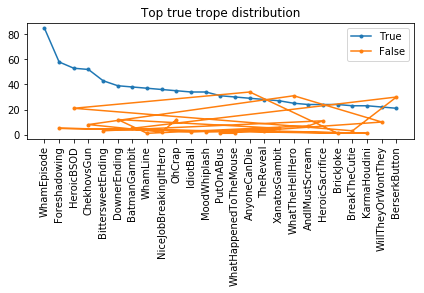

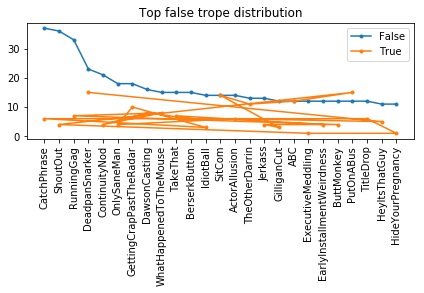

In [85]:
dfTrain = pd.read_csv("train.csv")
# get training features and labels
x_true = dfTrain.loc[dfTrain['spoiler'] == 1]
x_false = dfTrain.loc[dfTrain['spoiler'] == 0]

grouped_trope_true = x_true.groupby('trope').size().sort_values(ascending=False)
grouped_trope_false = x_false.groupby('trope').size().sort_values(ascending=False)

plt.xticks(rotation='vertical')
plt.gca().set_xticklabels(grouped_trope_true.index)
l1, = plt.plot(grouped_trope_true[0:25].values, label='True', marker='.')
l2, = plt.plot(grouped_trope_true[grouped_trope_false[0:25].index], label='False', marker='.')
plt.legend(handles=[l1, l2])
plt.tight_layout()
plt.title('Top true trope distribution')
plt.show()

plt.gca().set_xticklabels(grouped_trope_false.index)
plt.legend()
plt.xticks(rotation='vertical')
l1, = plt.plot(grouped_trope_false[0:25].values, label='False', marker='.')
l2, = plt.plot(grouped_trope_false[grouped_trope_true[0:25].index], label='True', marker='.')
plt.legend(handles=[l1, l2])
plt.tight_layout()
plt.title('Top false trope distribution')
plt.show()

#### 2 - cleaned unigrams and bigrams of tropes <br/>
Tropes capture the essence the sentence, some sentences which are spoilers cannot be spotted because the words in it are not always predictive, however, tropes succintly establish the relationship between the sentence and the context of the show which indicates that it is a useful feature.
As seen from the above plots, the top spoiler tropes and top non spoiler tropes are quite distinct. The words that make the tropes are distinct too, with spoilers having words like kill,death,wham etc..However, the tropes in the training set and test set are not necessarily the same, which makes including just the trope an inadequate feature. Hence, it is first tokenized, lemmatized and stemmed to get predictive words out of it in a small feature space.

For example -<br/>
The following sentences are spoilers but get misclassified, but including the trope feature helps reclassify it as a spoiler, as the tropes for this sentences are some of the top spoiler predictors.

sentence - Bill   sees his obituary  in a stack of old newspapers she was going to throw away.<br/>
trope - DeadAllAlong

sentence - Two years later, he shows up   marries Val.<br/>
trope - Foreshadowing

The best and worst trope predictors are -<br/>
__Pos: wham episod cliffhang love heroic gambit reveal suicid foreshadow wham dead end death kill <br/>
Neg: show com that flander catchphras dysfunct famili cast celebr phrase reviv foreign british pilot network fantast__

It can be seen that, the feature does a good job of capturing the themes most frequently seen in spoilers, the pre-processing ensures that it is general enough to perform well on the test set as well.

This feature alone gives an cross-validation score of 71%, However, if the tropes are not lemmatized,stemmed and tokenized, it gives a meagre 57%

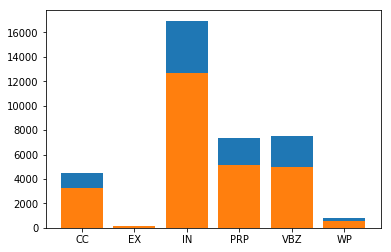

In [103]:
dfTrain = pd.read_csv("train.csv")


# get training features and labels
x_true = dfTrain.loc[dfTrain['spoiler'] == 1]
x_false = dfTrain.loc[dfTrain['spoiler'] == 0]

true_sentences = list(x_true['sentence'])
false_sentences = list(x_false['sentence'])

true = {'WP': 0, 'IN': 0, 'EX': 0, 'PRP': 0, 'CC': 0, 'VBZ': 0}
false = {'WP': 0, 'IN': 0, 'EX': 0, 'PRP': 0, 'CC': 0, 'VBZ': 0}

for sentence in true_sentences:
    text = nltk.word_tokenize(sentence)
    tags = nltk.pos_tag(text)
    for tag in tags:
        if tag[-1] == 'WP':
            true['WP'] += 1
        if tag[-1] == 'IN':
            true['IN'] += 1
        if tag[-1] == 'EX':
            true['EX'] += 1
        if tag[-1] == 'PRP':
            true['PRP'] += 1
        if tag[-1] == 'CC':
            true['CC'] += 1
        if tag[-1] == 'VBZ':
            true['VBZ'] += 1

for sentence in false_sentences:
    text = nltk.word_tokenize(sentence)
    tags = nltk.pos_tag(text)
    for tag in tags:
        if tag[-1] == 'WP':
            false['WP'] += 1
        if tag[-1] == 'IN':
            false['IN'] += 1
        if tag[-1] == 'EX':
            false['EX'] += 1
        if tag[-1] == 'PRP':
            false['PRP'] += 1
        if tag[-1] == 'CC':
            false['CC'] += 1
        if tag[-1] == 'VBZ':
            false['VBZ'] += 1


plt.bar(true.keys(), true.values())
plt.bar(false.keys(), false.values())
plt.legend()
plt.show()

#### 3 - parts of speech tags <br/>
Spoilers in general tend to be more emotive/action oriented in nature, thus, parts of speech were incorporated as a feature. The above distribution shows how spoilers and non-spoliers fare for the top predictors for part of speech tags. While there isn't a considerable difference in the number of tags for each part-of-speech, It still acts a good supporting feature because it picks on things like interjections, verbs and tenses.

The top predictors for part of speech tags are as follows - 

__Pos: wp in ex prp cc to vbz rp pdt pos <br/>
Neg: fw ls jjr rbs jjs nnps vbp nns uh nn__

The feature alone gives an unimpressive cross val score of 60%, however, when combined with all the other features it raises the cross val score of the model to 74%

In addition to these features, the following features were examined :
    1. Genre of the series
    2. Running time of the series
    3. Year of the release
    4. Number of seasons in the series
    5. Name of the series
    6. Length of the sentence
    7. Sentiment of the sentence
    8. Sentiment of the trope
However, these did not prove useful in making the model better at predictions.

__These three features give an overall accuracy of 72.5% on kaggle and a cross val score of 74% on the traning data__